<a id='section_id3'></a>

# Auslegung Speicherleistung - Lastprofil 31 und 10kWp PV

Bei Batteriespeichern spielt die Speicherleistung keine große Rolle, da hier ausreichend hohe Leistungen ohne großen Aufwand umgesetzt werden können. Hier wird daher die Auslegung von Elektrolyseur und Brennstoffzelle untersucht. Dabei ist die Annahme eine unbegrenzte Speicherkapazität zur Verfügung zu haben.


## Formelzeichen

\begin{eqnarray}
P_{Einspeicher\_max} &=& Maximalleistung\ des\ Einspeicherung\ in\ W\\
P_{Ausspeicher\_max} &=& Maximalleistung\ der\ Ausspeicherung\ in\ W\\
eff_{Speicher} &=& Wirkungsgrad\ des\ Speichers\\
\\
E_{Elektrolyseur} &=& Durch\ Elektrolyse\ über\ ein\ Jahr\ in\ Wasserstoff\ umgesetzte\ Energie\\
E_{Elektrolyseur\_Verluste} &=& Durch\ Elektrolyse\ umgesetzte\ Energie\ die\ nach\ Rückverstromung\ wieder\ verfügbar\ wird\ (Annahme\ ausreichend\ große\ Brennstoffzelle)\\
E_{Brennstoffzelle} &=& Durch\ Brennstoffzelle\ über\ ein\ Jahr\ rückverstromte\ Energie\ (Annahme\ unbegrenzte\ Wasserstoffmenge)\\
\end{eqnarray}

\
Verwendete Skripte:\
[Parameter Base Case](parameter_base_case.py)\
[Hilfsfunktionen](own_utility_functions.py)\
[Visualisierung](visualisation.py)\
[Speicher](speicher.py)


## Initialisierung

In [1]:
#Parameter und Standardlastprofile laden
from parameter_base_case import *

Nummer = '31' 

directory = directory_data+'Lastprofil_' + Nummer +'.npy'
with open(directory, 'rb') as f:
    [P_verbraucher, P_pv, P_dif, P_def, P_ueber] = np.load(f)

E_verbraucher = jahresenergie_kWh(P_verbraucher)
E_pv = jahresenergie_kWh(P_pv)
E_def = jahresenergie_kWh(P_def)
E_ueber = jahresenergie_kWh(P_ueber)



# -------------------------------------------------------------------------------------------------------------

## Ansatz Histogramm für Berechnung der maximal umsetzbaren Energie

Die zeitliche Verteilung der Differenzleistung im Haushalt wird berechnet um festzustellen wie viel Energie vom Speicher umgesetzt werden kann. Die Maximalleistung bei der Ein- und Ausspeicherung begrenzt die Umsetzung mit beliebig hoher Leistung.

Es muss jedoch beachtet werden, dass das System bei über der Maximalleistung liegenden Leistungen nicht komplett abgeschaltet wird sondern an der Obergrenze weiterläuft.

### Darstellung ausführlich (mit Rückverstromungsverlusten und Abgleich mit speicher.py Implementierung)

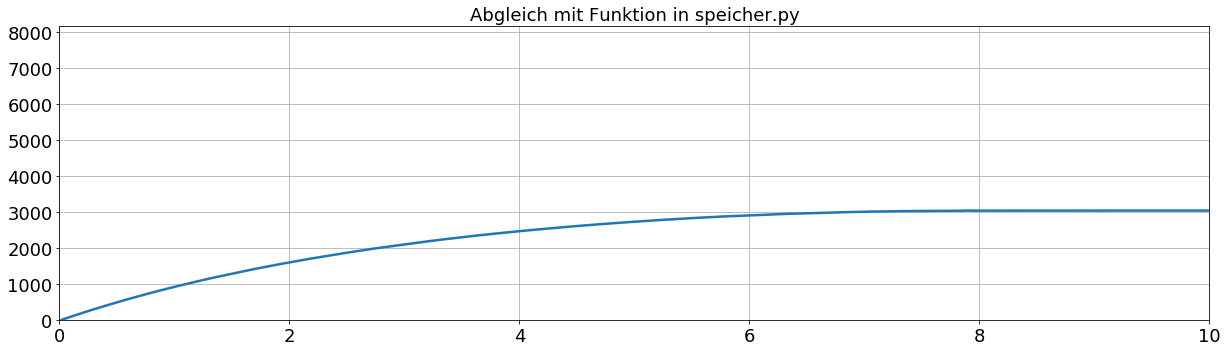

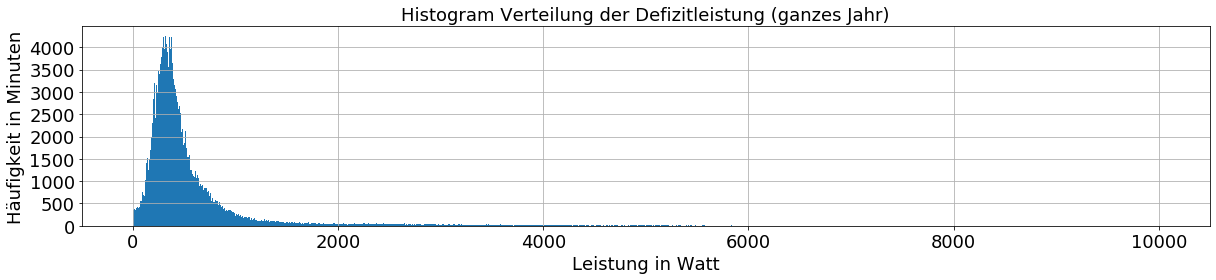

In [7]:

##Histogramm Überproduktion erstellen
upperlim=10000
bins, n, ax = vis.histogram(np.arange(0.01,upperlim,5),P_ueber,'Leistung in Watt','Häufigkeit in Minuten',\
                        'Histogram Verteilung der Überschussleistung (ganzes Jahr)')
vis.save_to_tex('diagramm_histogramm_ueberschussleistung',ax)

##Häufigkeit über Leistung aufintegrieren --> Energie
integral=np.zeros(np.size(n))
for i, value in enumerate(n):
    if i>0:
        integral[i]=integral[i-1]+average(bins[i],bins[i-1])*value/1000/60
##Bei Überschreiten der Max-Leistung wird mit Max-Leistung weitergearbeitet und nicht abgeschaltet        
for i, value in enumerate(n):    
    integral[i]=integral[i]+np.sum(n[i:np.size(n)])*bins[i]/60/1000
##Ergebnis    
P_elektrolyse_max_array=bins[1:np.size(bins)]
E_h2=integral*eff_elektrolyse
E_h2_elektro_netto=E_h2*eff_brennstoffzelle
E_waerme_einspeichern = integral*eff_elektrolyse_waerme

ax=vis.plot(P_elektrolyse_max_array/1000, E_h2_elektro_netto, 'Maximalleistung Elektrolyseur in kW', \
         'umgesetzte \n Überschussenergie in kWh', 'Einfluss Elektrolyseur Größe auf Speicherung der Überschussenergie')
vis.addtoplot(ax,P_elektrolyse_max_array/1000, E_h2,'','best')
legend=['nach Ausspeicherung des $H_2$ übrig','eingespeichert als $H_2$','insgesamt verfügbar '+"%4.0f" % E_ueber +'kWh']
vis.addtoplot(ax,[0, upperlim/1000],[E_ueber,E_ueber],legend,'best')
legend.append('Wärmeenergie Einspeichern')
vis.addtoplot(ax, P_elektrolyse_max_array/1000, E_waerme_einspeichern,legend,'best',3)

#vis.save_to_tex('diagramm_speichermaxleistung_einspeichermenge'+'_'+file_extension,ax)


#Abgleich mit Funktionen in speicher.py
P_elektrolyse_max_array_test, E_ausspeicher=speicher.RFC(P_ueber,eff_brennstoffzelle, eff_elektrolyse)
ax=vis.plot(P_elektrolyse_max_array_test/1000, E_ausspeicher,'','','Abgleich mit Funktion in speicher.py')
ax.set_xlim(0,upperlim/1000)
ax.set_ylim(0,E_ueber)

##Histogramm Defizit erstellen
upperlim=10000
bins, n, ax = vis.histogram(np.arange(0.01,upperlim,5),P_def,'Leistung in Watt','Häufigkeit in Minuten',\
                        'Histogram Verteilung der Defizitleistung (ganzes Jahr)')
vis.save_to_tex('diagramm_histogramm_defizitleistung',ax)

##Häufigkeit über Leistung aufintegrieren --> Energie
integral=np.zeros(np.size(n))
for i, value in enumerate(n):
    if i>0:
        integral[i]=integral[i-1]+average(bins[i],bins[i-1])*value/1000/60
##Bei Überschreiten der Max-Leistung wird mit Max-Leistung weitergearbeitet und nicht abgeschaltet        
for i, value in enumerate(n):    
    integral[i]=integral[i]+np.sum(n[i:np.size(n)])*bins[i]/60/1000

##Ergebnis
P_brennstoffzelle_max_array=bins[1:np.size(bins)]
E_brennstoffzelle_input=integral/eff_brennstoffzelle
E_ausspeicher=integral
E_brennstoffzelle=E_ausspeicher
E_waerme_ausspeichern=E_brennstoffzelle_input*eff_brennstoffzelle_waerme
ax=vis.plot(P_brennstoffzelle_max_array/1000, E_ausspeicher, 'Maximalleistung Brennstoffzelle in kW', \
         'zurückgewandelte \n Speicherenergie in kWh', 'Einfluss Brennstoffzellen Größe auf Deckung des Defizit')
legend=['aus $H_2$ rückverstromt','Bedarf '+"%4.0f" % E_def +'kWh']
vis.addtoplot(ax,[0, upperlim/1000],[E_def,E_def],legend,'best')
legend.append('Wärmeenergie Ausspeicherung')
vis.addtoplot(ax,P_brennstoffzelle_max_array/1000,E_waerme_ausspeichern,legend,'best',3)

### einfache Darstellung

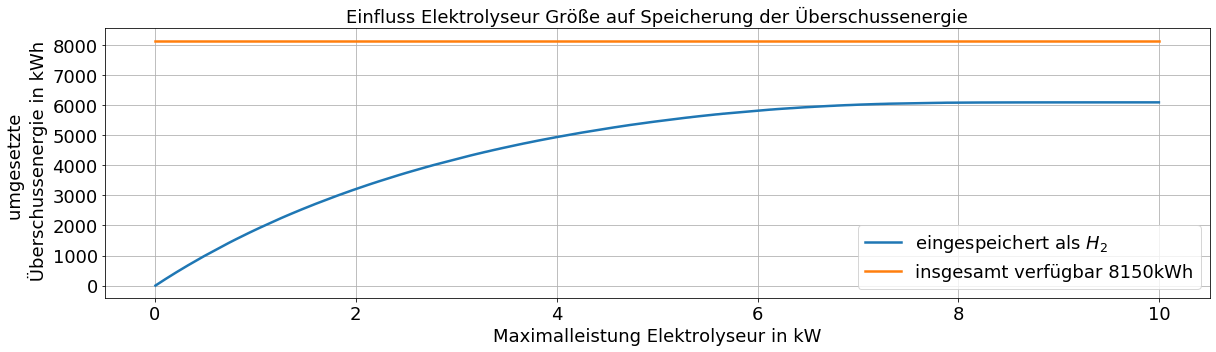

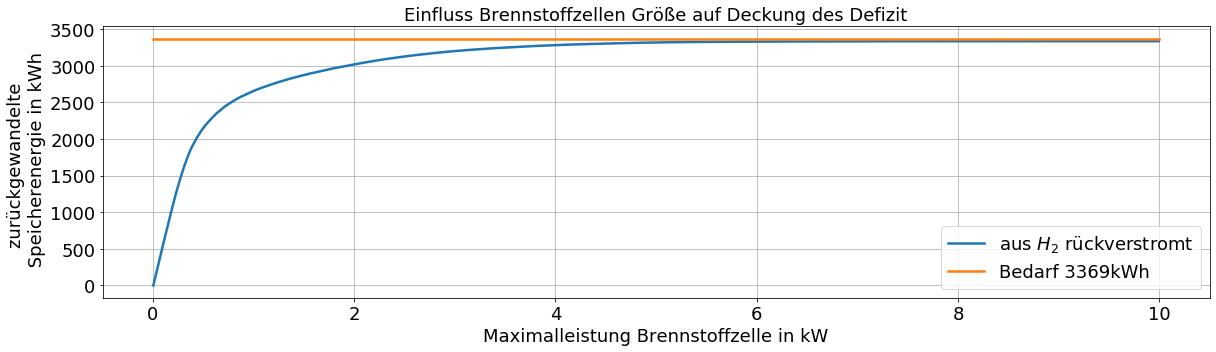

In [8]:

ax=vis.plot(P_elektrolyse_max_array/1000, E_h2, 'Maximalleistung Elektrolyseur in kW', \
         'umgesetzte \n Überschussenergie in kWh', 'Einfluss Elektrolyseur Größe auf Speicherung der Überschussenergie')
legend=['eingespeichert als $H_2$','insgesamt verfügbar '+"%4.0f" % E_ueber +'kWh']
vis.addtoplot(ax,[0, upperlim/1000],[E_ueber,E_ueber],legend,'best')
legend.append('Wärmeenergie Einspeichern')
#vis.addtoplot(ax, P_elektrolyse_max_array/1000, E_waerme_einspeichern,legend,'best',3)
vis.save_to_tex('diagramm_elektrolyseurleistung_einspeichereinfluss',ax)

ax=vis.plot(P_brennstoffzelle_max_array/1000, E_ausspeicher, 'Maximalleistung Brennstoffzelle in kW', \
         'zurückgewandelte \n Speicherenergie in kWh', 'Einfluss Brennstoffzellen Größe auf Deckung des Defizit')
legend=['aus $H_2$ rückverstromt','Bedarf '+"%4.0f" % E_def +'kWh']
vis.addtoplot(ax,[0, upperlim/1000],[E_def,E_def],legend,'best')
legend.append('Wärmeenergie Ausspeicherung')
#vis.addtoplot(ax,P_brennstoffzelle_max_array/1000,E_waerme_ausspeichern,legend,'best',3)
vis.save_to_tex('diagramm_brennstoffzellenleistung_ausspeichereinfluss',ax)


ax=vis.plot(P_elektrolyse_max_array/1000, E_h2_elektro_netto, 'Maximalleistung Elektrolyseur in kW', \
         'umgesetzte \n Überschussenergie in kWh', 'Deckung Defizit durch Wasserstoffrückverstromung')
legend=['nach Ein/Ausspeicherung verfügbar','Defizit']
vis.addtoplot(ax,[0, upperlim/1000],[E_def,E_def],legend,'best',1)
vis.save_to_tex('diagramm_defizitabdeckung_RFC',ax)

## Verhältnis Einspeicherleistung zu Ausspeicherleistung

Idee: Ausspeicherleistung muss nur so groß sein, dass die Eingespeicherte Energie gerade noch vollständig rückverstromt werden kann

In [4]:
E_elektrolyse_verlust=E_h2*eff_brennstoffzelle

ax=vis.plot(E_elektrolyse_verlust,P_elektrolyse_max_array,'Umgesetzte Energie in kWh','Leistung in W')
vis.addtoplot(ax,E_brennstoffzelle,P_brennstoffzelle_max_array,['Elektrolyseur','Brennstoffzelle'])

P_brennstoffzelle_max_new=np.zeros(len(P_elektrolyse_max_array))
for i,value in enumerate(E_elektrolyse_verlust):
    element=find_value(E_brennstoffzelle,value)
    P_brennstoffzelle_max_new[i]=P_brennstoffzelle_max_array[element]

vis.plot_korrelation(P_elektrolyse_max_array[0::50],P_brennstoffzelle_max_new[0::50],'Elektrolyseurleistung in W',\
                     'Brennstoffzellenleistung in W','Korrelation Brennstoffzellenleistung zu Elektrolyseurleistung')

vis.save_to_tex('diagramm_korrelation_einausspeicherleistung',ax)

## Ergebnis:

- Einspeichgerleistung >5kW führt zu keiner großen Verbesserung - kleiner Elektrolyseur ca 2kW bereits sehr gut
- Ausspeicherleistung muss selten größer 1kW sein --> Brennstoffzelle kann kleiner als Elektrolyseur sein
- Dimensionierung Brennstoffzelle ca ein zehntel der Elektrolyseurleistung ausreichend für vollständige Rückverstromung